In [1]:
PATH_ = "C:\\Users\\ICN_admin\\Dropbox (Brain Modulation Lab)\\Shared Lab Folders\\CRCNS\\MOVEMENT DATA\\derivatives\\Int_old_grid\\"

In [8]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn import linear_model, metrics
from sklearn.model_selection import cross_val_score
import os 
from matplotlib import pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
import seaborn as sb
import pandas as pd
import numpy as np
from scipy import stats
import sys
sys.path.append('C:\\Users\\ICN_admin\\Documents\\icn\\icn_stats\\')
import icn_permutation_test

In [3]:
def append_time_dim(arr, y_, time_stamps):
    """
    apply added time dimension for the data array and label given time_stamps (with downsample_rate=100) in 100ms / need to check with 1375Hz
    """
    time_arr = np.zeros([arr.shape[0]-time_stamps, int(time_stamps*arr.shape[1])])
    for time_idx, time_ in enumerate(np.arange(time_stamps, arr.shape[0])):
        for time_point in range(time_stamps):
            time_arr[time_idx, time_point*arr.shape[1]:(time_point+1)*arr.shape[1]] = arr[time_-time_point,:]
    return time_arr, y_[time_stamps:]

In [4]:
def evalerror(preds, dtrain):
        """
        Custom defined r^2 evaluation function
        """
        labels = dtrain.get_label()
        # return a pair metric_name, result. The metric name must not contain a
        # colon (:) or a space since preds are margin(before logistic
        # transformation, cutoff at 0)

        r2 = metrics.r2_score(labels, preds)

        if r2 < 0:
            r2 = 0

        return 'r2', r2

In [114]:
model = xgb.XGBRegressor()
df = pd.DataFrame()
for f in range(len(os.listdir(PATH_))):
    sub_ = os.listdir(PATH_)[f][4:7]
    if sub_ not in ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']:
        continue
    print(sub_)
    with open(PATH_+ '\\'+ os.listdir(PATH_)[f], 'rb') as handle:
        run_ = pickle.load(handle)
        print(run_["ch_names"])
        if len([ch for ch in run_["ch_names"] if "STN" in ch]) == 0:
            continue
        print("PROCESS")
        for ch_idx, ch_ in enumerate([ch for ch in run_["ch_names"] if "MOV" not in ch]):
            if "ECOG" in ch_:
                loc = "ECOG"
            else:
                loc = "STN"
            for label_idx, label in enumerate(run_["label_baseline_corrected"]):
                if run_["label_con_true"][label_idx] is True:
                    lat = "CON"
                else:
                    lat = "IPS"
                X, y = append_time_dim(run_["rf_data_median"][:,ch_idx,:], label, time_stamps=5)
                #res_ = np.mean(cross_val_score(model, X, y, cv=3, scoring="r2", n_jobs=59))
                #res_ = xgb.cv(xgb.XGBRegressor().get_params(), dtrain=xgb.DMatrix(X, label=y), 
                #              feval=evalerror, nfold=3).iloc[-1]["test-r2-mean"]
                # REPLACE this CV by the 3 fold CV: 
                r2_here = []
                importances_ = []
                for f in range(3):
                    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
                    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
                    dict_= xgb.XGBRegressor().get_params()
                    #dict_["eval_metric"]:evalerror
    
                    model = xgb.train(
                        params=dict_,
                        dtrain=xgb.DMatrix(X_train, label=y_train),
                        num_boost_round=50,
                        evals=[(xgb.DMatrix(X_val, label=y_val), "Val")],
                        early_stopping_rounds=10, 
                        #feval = evalerror, 
                        maximize = False
                    )
                    
                    #xgb_trained = xgb.XGBRegressor().fit(X_train, y_train, eval_metric =evalerror)
                    r2_ = metrics.r2_score(model.predict(xgb.DMatrix(X_test)), y_test)
                    
                    if r2_ < 0:
                        r2_here.append(0)
                    else:
                        r2_here.append(r2_)
                    importances_.append(model.feature_importances_)
                print(np.mean(r2_here))
                if "LEFT" in ch_:
                    hem = "LEFT"
                else:
                    hem = "RIGHT"
                df = df.append({
                    "r2": np.mean(r2_here),
                    "ch_": ch_,
                    "sub": sub_,
                    "loc": loc,
                    "lat": lat,
                    "hem" : hem, 
                    "importances" : np.mean(np.array(importances_), axis=0)
                }, ignore_index=True)
            

000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
PROCESS
[0]	Val-rmse:0.37264
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29950
[2]	Val-rmse:0.25698
[3]	Val-rmse:0.23547
[4]	Val-rmse:0.22314
[5]	Val-rmse:0.21788
[6]	Val-rmse:0.21398
[7]	Val-rmse:0.21246
[8]	Val-rmse:0.21198
[9]	Val-rmse:0.21131
[10]	Val-rmse:0.21052
[11]	Val-rmse:0.20977
[12]	Val-rmse:0.20865
[13]	Val-rmse:0.21043
[14]	Val-rmse:0.21114
[15]	Val-rmse:0.21085
[16]	Val-rmse:0.20788
[17]	Val-rmse:0.20751
[

AttributeError: 'Booster' object has no attribute 'feature_importances_'

In [118]:
from xgboost import plot_importance

In [125]:
model.get_score(importance_type='gain')

{'f1': 0.1430888566621554,
 'f24': 0.24660939156453845,
 'f13': 0.09199577509022581,
 'f5': 0.06928504678664,
 'f0': 0.04841392269878528,
 'f20': 0.16745241496242855,
 'f3': 0.08512125724998999,
 'f6': 0.06111373945086758,
 'f17': 0.10716250689565214,
 'f2': 0.08694703019634498,
 'f16': 0.11876010205764001,
 'f34': 0.21466747841719996,
 'f11': 0.26113877080782494,
 'f28': 0.1937526896576471,
 'f39': 0.08371059696356521,
 'f9': 0.10634245798193485,
 'f38': 0.1671589393622903,
 'f33': 0.15965175679144736,
 'f37': 0.19216008192055556,
 'f10': 0.11940511123217856,
 'f26': 0.10555983394100002,
 'f29': 0.14511180516570835,
 'f35': 0.2098857711065305,
 'f8': 0.11435948962124999,
 'f19': 0.3262850236816667,
 'f23': 0.0629529513765625,
 'f30': 0.08858012387983785,
 'f14': 0.15138150945602002,
 'f22': 0.04485368055851852,
 'f25': 0.10776311612081818,
 'f21': 0.127613829086,
 'f15': 0.08138961216092305,
 'f7': 0.09201519640375004,
 'f31': 0.05676238008928002,
 'f27': 0.11687540989328003,
 'f4': 0

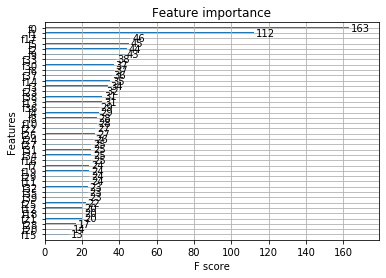

In [119]:
plot_importance(model)

In [31]:
dict_= xgb.XGBRegressor().get_params()
dict_["eval_metric"]:evalerror

In [26]:
model.predict?

In [20]:
X.shape

(2625, 40)

In [21]:
np.array(importances_).shape

(3, 40)

In [11]:
xgb_trained.feature_importances_

array([0.00501371, 0.02783468, 0.0369113 , 0.01006469, 0.01957654,
       0.0250236 , 0.02422877, 0.02138436, 0.03054538, 0.01076919,
       0.059793  , 0.00954712, 0.01367239, 0.01908868, 0.02035677,
       0.01473545, 0.00870746, 0.02745906, 0.03844301, 0.02353799,
       0.04415212, 0.04123663, 0.01690921, 0.00632539, 0.01929351,
       0.02124371, 0.04420314, 0.02316142, 0.01011597, 0.0222651 ,
       0.01480291, 0.00721231, 0.01554615, 0.04667889, 0.06761016,
       0.03325153, 0.04444684, 0.04186766, 0.02433931, 0.0086449 ],
      dtype=float32)

In [ ]:
xgb.XGBRegressor().fit

In [18]:
xgb.cv(xgb.XGBRegressor().get_params(), dtrain=xgb.DMatrix(X, label=y), feval=evalerror, nfold=3).iloc[-1]["test-r2-mean"]

0.5526003333333334

In [14]:
xgb.cv?

In [37]:
df_best = pd.DataFrame()
for sub in ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']:
    for lat in ["CON", "IPS"]:
        for loc in ["ECOG", "STN"]:
            for hem in ["RIGHT", "LEFT"]:
                df_extr = df[(df["sub"] == sub) & (df["lat"] == lat) & (df["loc"] == loc)]
                df_extr_cpy = df_extr.copy()
                for index, row in df_extr_cpy.iterrows():
                    if hem not in row["ch_"]:
                        df_extr = df_extr.drop(index)
                if df_extr.shape[0] != 0:
                    df_best = df_best.append(df_extr.loc[df_extr["r2"].argmax()], ignore_index=True)


C:\Users\ICN_admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  if sys.path[0] == '':


In [113]:
df

,ch_,hem,importances,lat,loc,r2,sub
0,STN_RIGHT_0,RIGHT,"[0.01002628, 0.01081586, 0.020139407, 0.025176...",IPS,STN,0.000000,000
1,STN_RIGHT_0,RIGHT,"[0.01002628, 0.01081586, 0.020139407, 0.025176...",CON,STN,0.255321,000
2,STN_RIGHT_1,RIGHT,"[0.01002628, 0.01081586, 0.020139407, 0.025176...",IPS,STN,0.000000,000
3,STN_RIGHT_1,RIGHT,"[0.01002628, 0.01081586, 0.020139407, 0.025176...",CON,STN,0.753078,000
4,STN_RIGHT_2,RIGHT,"[0.01002628, 0.01081586, 0.020139407, 0.025176...",IPS,STN,0.000000,000
...,...,...,...,...,...,...,...
661,ECOG_RIGHT_3,RIGHT,"[0.01002628, 0.01081586, 0.020139407, 0.025176...",CON,ECOG,0.000000,014
662,ECOG_RIGHT_4,RIGHT,"[0.01002628, 0.01081586, 0.020139407, 0.025176...",IPS,ECOG,0.000000,014
663,ECOG_RIGHT_4,RIGHT,"[0.01002628, 0.01081586, 0.020139407, 0.025176...",CON,ECOG,0.000000,014
664,ECOG_RIGHT_5,RIGHT,"[0.01002628, 0.01081586, 0.020139407, 0.025176...",IPS,ECOG,0.000000,014


In [112]:
df.sort_values("r2", ascending=False)

,ch_,hem,importances,lat,loc,r2,sub
7,ECOG_RIGHT_0,RIGHT,"[0.01002628, 0.01081586, 0.020139407, 0.025176...",CON,ECOG,0.826431,000
3,STN_RIGHT_1,RIGHT,"[0.01002628, 0.01081586, 0.020139407, 0.025176...",CON,STN,0.753078,000
13,ECOG_RIGHT_3,RIGHT,"[0.01002628, 0.01081586, 0.020139407, 0.025176...",CON,ECOG,0.699700,000
9,ECOG_RIGHT_1,RIGHT,"[0.01002628, 0.01081586, 0.020139407, 0.025176...",CON,ECOG,0.684668,000
11,ECOG_RIGHT_2,RIGHT,"[0.01002628, 0.01081586, 0.020139407, 0.025176...",CON,ECOG,0.658610,000
...,...,...,...,...,...,...,...
243,ECOG_LEFT_3,LEFT,"[0.01002628, 0.01081586, 0.020139407, 0.025176...",IPS,ECOG,0.000000,006
244,ECOG_LEFT_4,LEFT,"[0.01002628, 0.01081586, 0.020139407, 0.025176...",CON,ECOG,0.000000,006
245,ECOG_LEFT_4,LEFT,"[0.01002628, 0.01081586, 0.020139407, 0.025176...",IPS,ECOG,0.000000,006
246,ECOG_LEFT_5,LEFT,"[0.01002628, 0.01081586, 0.020139407, 0.025176...",CON,ECOG,0.000000,006


In [98]:
i_ = []
for i in df.sort_values("r2", ascending=False)[:10]["importances"]:
    i_.append(i)

In [107]:
np.array(i_).shape

(10, 40)

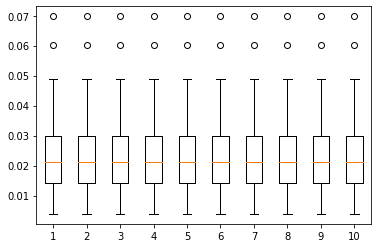

In [110]:
plt.boxplot(np.array(i_).T)
plt.show()

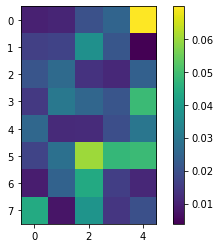

In [100]:
plt.imshow(np.array(i_).mean(axis=0).reshape((8,5), order="C"))
plt.colorbar()

In [66]:
np.reshape?

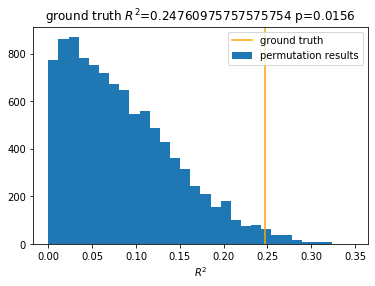

(0.24760975757575754, 0.0156)

In [21]:
icn_permutation_test.permutationTest(df_best[(df_best["lat"]=="CON") & (df_best["loc"] == "ECOG")]["r2"],
                                    df_best[(df_best["lat"]=="CON") & (df_best["loc"] == "STN")]["r2"], True,
                                    r"$R^2$", 10000)

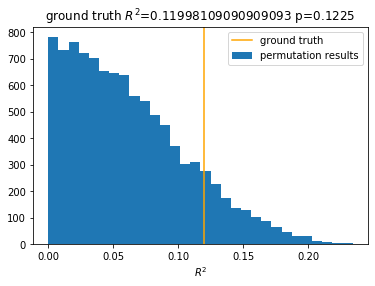

(0.11998109090909093, 0.1225)

In [22]:
icn_permutation_test.permutationTest(df_best[(df_best["lat"]=="IPS") & (df_best["loc"] == "ECOG")]["r2"],
                                    df_best[(df_best["lat"]=="IPS") & (df_best["loc"] == "STN")]["r2"], True,
                                    r"$R^2$", 10000)

In [10]:
df_best.to_pickle("XGB_best_ECOGSTN_samesize.p")

In [6]:
df.to_pickle("XGB_all_ECOGSTN_samesize.p")

In [38]:
s_ECOG_CON = str(np.round(df_best[(df_best["lat"] == "CON") & (df_best["loc"] == "ECOG")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df_best[(df_best["lat"] == "CON") & (df_best["loc"] == "ECOG")]["r2"].std(),2))
s_ECOG_IPS = str(np.round(df_best[(df_best["lat"] == "IPS") & (df_best["loc"] == "ECOG")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df_best[(df_best["lat"] == "IPS") & (df_best["loc"] == "ECOG")]["r2"].std(),2))
s_STN_CON = str(np.round(df_best[(df_best["lat"] == "CON") & (df_best["loc"] == "STN")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df_best[(df_best["lat"] == "CON") & (df_best["loc"] == "STN")]["r2"].std(),2))
s_STN_IPS = str(np.round(df_best[(df_best["lat"] == "IPS") & (df["loc"] == "STN")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df_best[(df_best["lat"] == "IPS") & (df_best["loc"] == "STN")]["r2"].std(),2)) 


C:\Users\ICN_admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Text(0.5, 1.0, 'XGB Cross Validation $R^2$ results\nECOG con: 0.17$\\pm$0.28 ips: 0.06$\\pm$0.14\nSTN con: 0.05$\\pm$0.19 ips: 0.1$\\pm$0.0')

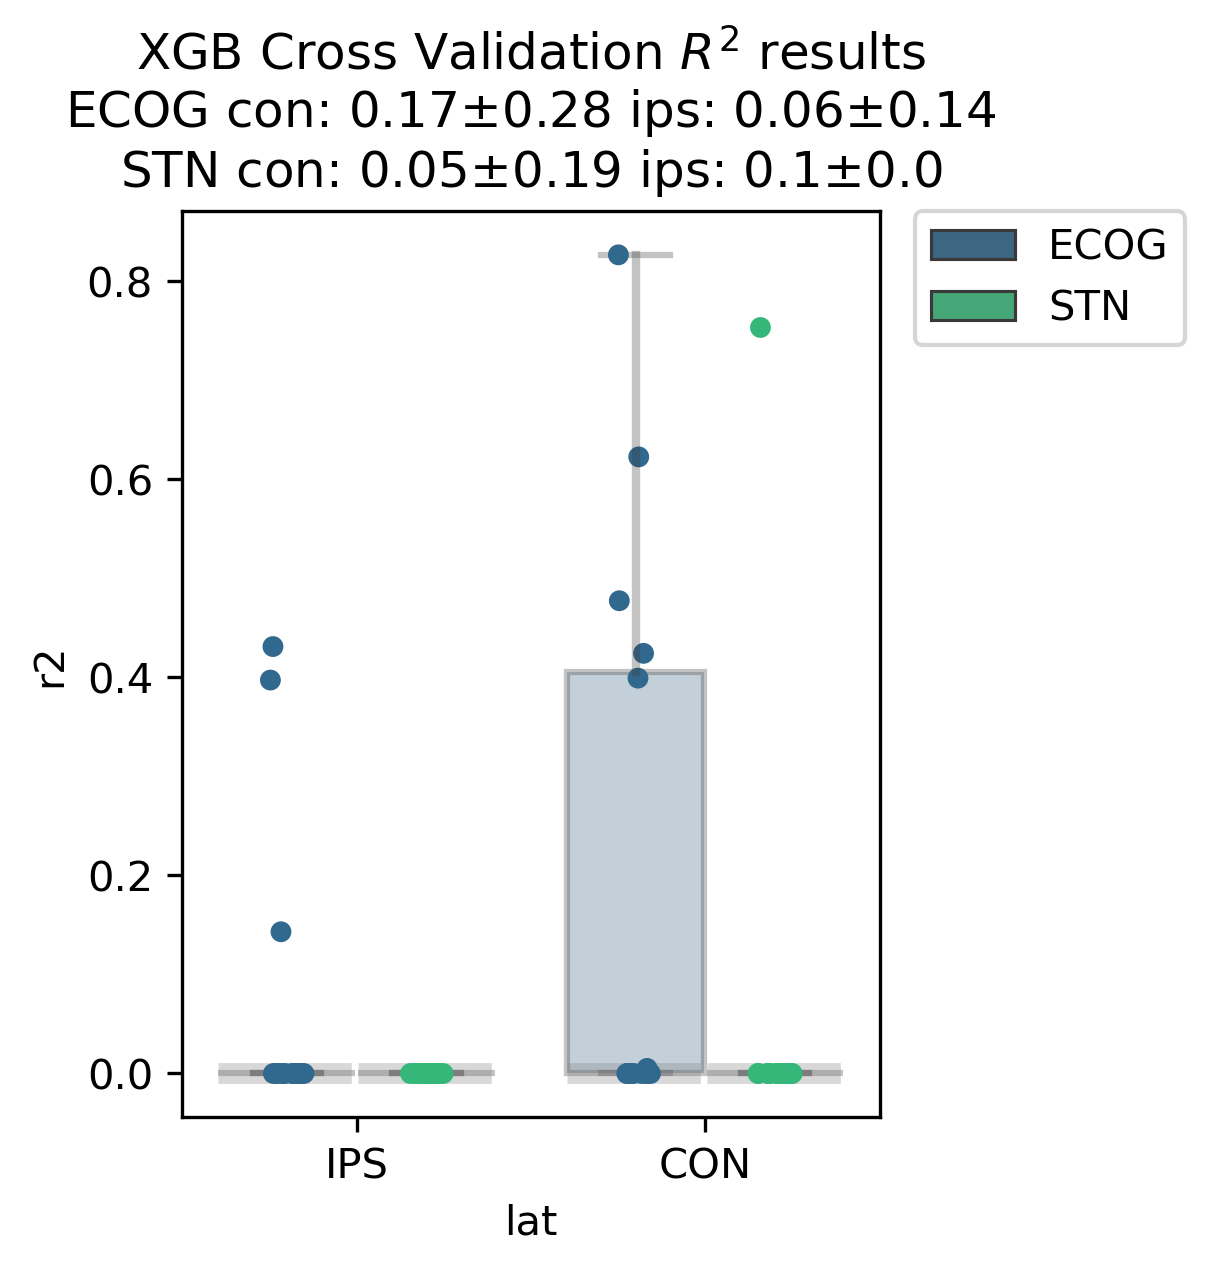

In [39]:
alpha_box = 0.3
plt.figure(figsize=(3,4), dpi=300)
sb.boxplot(x="lat", y="r2", hue="loc", order=["IPS", "CON"], data=df_best,
           palette="viridis", 
           showmeans=False, boxprops=dict(alpha=alpha_box), showcaps=True, showbox=True, 
           showfliers=False, notch=False,
           whiskerprops={'linewidth':2, "zorder":10, "alpha":alpha_box},
           capprops={"alpha":alpha_box},
           medianprops=dict(linestyle='-.', linewidth=5, color="gray", alpha=alpha_box))

    
ax = sb.stripplot(x="lat", y="r2", hue="loc", order=["IPS", "CON"], 
             data=df_best, palette="viridis", dodge=True, s=5)
#plt.xticks(rotation=90)

# When creating the legend, only use the first two elements
# to effectively remove the last two.
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("XGB Cross Validation "+r"$R^2$"+" results\n"+
          "ECOG con: "+s_ECOG_CON+ " ips: "+s_ECOG_IPS+\
         "\nSTN con: "+s_STN_CON+ " ips: "+s_STN_IPS)


Text(0.5, 1.0, 'XGB Cross Validation $R^2$ results\nECOG con: 0.34$\\pm$0.23 ips: 0.19$\\pm$0.2\nSTN con: 0.1$\\pm$0.17 ips: 0.03$\\pm$0.1')

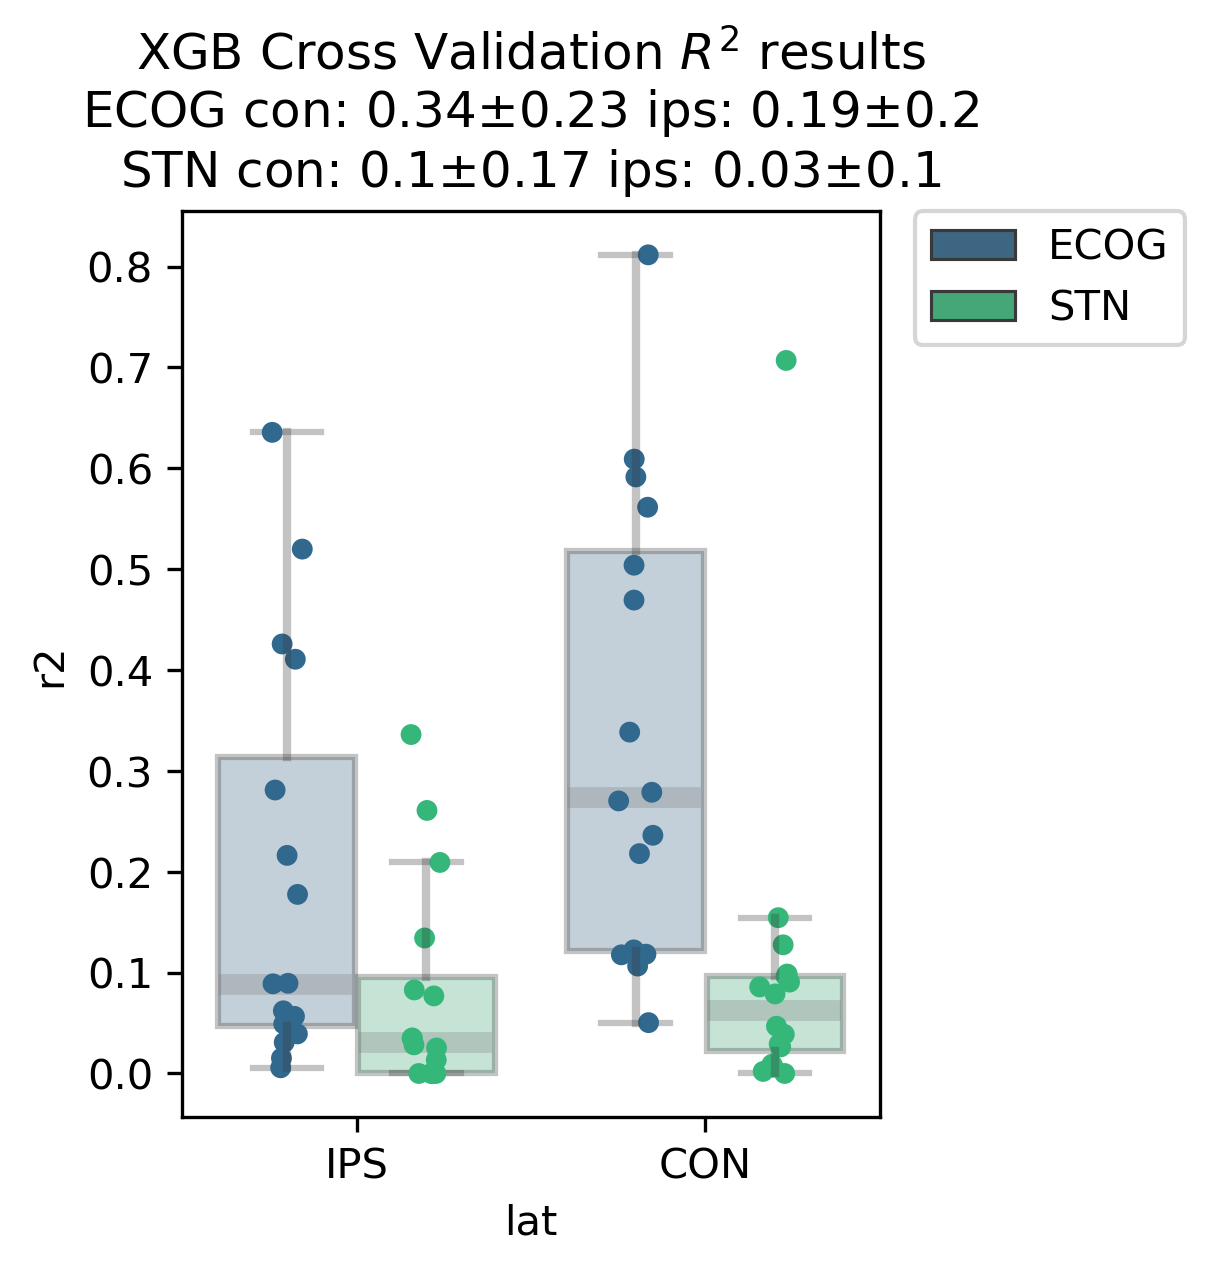

In [44]:
alpha_box = 0.3
plt.figure(figsize=(3,4), dpi=300)
sb.boxplot(x="lat", y="r2", hue="loc", order=["IPS", "CON"], data=df_best,
           palette="viridis", 
           showmeans=False, boxprops=dict(alpha=alpha_box), showcaps=True, showbox=True, 
           showfliers=False, notch=False,
           whiskerprops={'linewidth':2, "zorder":10, "alpha":alpha_box},
           capprops={"alpha":alpha_box},
           medianprops=dict(linestyle='-.', linewidth=5, color="gray", alpha=alpha_box))

    
ax = sb.stripplot(x="lat", y="r2", hue="loc", order=["IPS", "CON"], 
             data=df_best, palette="viridis", dodge=True, s=5)
#plt.xticks(rotation=90)

# When creating the legend, only use the first two elements
# to effectively remove the last two.
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("XGB Cross Validation "+r"$R^2$"+" results\n"+
          "ECOG con: "+s_ECOG_CON+ " ips: "+s_ECOG_IPS+\
         "\nSTN con: "+s_STN_CON+ " ips: "+s_STN_IPS)


In [28]:
# COMBINATION ECOG
model = linear_model.LinearRegression()
df = pd.DataFrame()
time_stamps = 5

for ch_USED in ["ECOG", "STN","ECOG_STN"]:
    for f in range(len(os.listdir(PATH_))):
        sub_ = os.listdir(PATH_)[f][4:7]
        if sub_ not in ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']:
            continue
        print(sub_)
        with open(PATH_+ '\\'+ os.listdir(PATH_)[f], 'rb') as handle:
            run_ = pickle.load(handle)
            print(run_["ch_names"])
            if len([ch for ch in run_["ch_names"] if "STN" in ch]) == 0:
                continue
            print("PROCESS")
            X_ = []
            start = True
            for ch_idx, ch_ in enumerate([ch for ch in run_["ch_names"] if "MOV" not in ch]):
                if ch_USED == "ECOG" and "ECOG" not in ch_:
                    continue
                if ch_USED == "STN" and "STN" not in ch_:
                    continue
                #ECOG_STN combines all 
                X, y = append_time_dim(run_["rf_data_median"][:,ch_idx,:], \
                                       run_["label_baseline_corrected"][0,:], \
                                       time_stamps=time_stamps)
                if start == True:
                    X_ = X
                    start = False
                else:
                    X_ = np.concatenate((X_, X), axis=1)

            for label_idx, label in enumerate(run_["label_baseline_corrected"]):
                res_ = xgb.cv(xgb.XGBRegressor().get_params(), dtrain=xgb.DMatrix(X_, label=label[time_stamps:]), 
                              feval=evalerror, nfold=3).iloc[-1]["test-r2-mean"]
                
                if res_ < 0:
                    res_ = 0
                if run_["label_con_true"][label_idx] is True:
                    lat = "CON"
                else:
                    lat = "IPS"
                df = df.append({
                    "r2": res_,
                    "ch_": ch_,
                    "sub": sub_,
                    "loc": ch_USED,
                    "lat": lat
                }, ignore_index=True)


000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
PROCESS
001
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'ECOG_LEFT_20', 'ECOG_LEFT_21', 'ECOG_LEFT_22', 'ECOG_LEFT_23', 'ECOG_LEFT_24', 'ECOG_LEFT_25', 'ECOG_LEFT_26', 'ECOG_LEFT_27', 

['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'ECOG_RIGHT_8', 'ECOG_RIGHT_9', 'ECOG_RIGHT_10', 'ECOG_RIGHT_11', 'ECOG_RIGHT_12', 'ECOG_RIGHT_13', 'ECOG_RIGHT_14', 'ECOG_RIGHT_15', 'ECOG_RIGHT_16', 'ECOG_RIGHT_17', 'ECOG_RIGHT_18', 'ECOG_RIGHT_19', 'ECOG_RIGHT_20', 'ECOG_RIGHT_21', 'ECOG_RIGHT_22', 'ECOG_RIGHT_23', 'ECOG_RIGHT_24', 'ECOG_RIGHT_25', 'ECOG_RIGHT_26', 'ECOG_RIGHT_27', 'MOV_RIGHT', 'MOV_LEFT']
006
['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'ECOG_RIGHT_8', 'ECOG_RIGHT_9', 'ECOG_RIGHT_10', 'ECOG_RIGHT_11', 'ECOG_RIGHT_12', 'ECOG_RIGHT_13', 'ECOG_RIGHT_14', 'ECOG_RIGHT_15', 'ECOG_RIGHT_16', 'ECOG_RIGHT_17', 'ECOG_RIGHT_18', 'ECOG_RIGHT_19', 'ECOG_RIGHT_20', 'ECOG_RIGHT_21', 'ECOG_RIGHT_22', 'ECOG_RIGHT_23', 'ECOG_RIGHT_24', 'ECOG_RIGHT_25', 'ECOG_RIGHT_26', 'ECOG_RIG

001
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'ECOG_RIGHT_8', 'ECOG_RIGHT_9', 'ECOG_RIGHT_10', 'ECOG_RIGHT_11', 'ECOG_RIGHT_12', 'ECOG_RIGHT_13', 'ECOG_RIGHT_14', 'ECOG_RIGHT_15', 'ECOG_RIGHT_16', 'ECOG_RIGHT_17', 'ECOG_RIGHT_18', 'ECOG_RIGHT_19', 'ECOG_RIGHT_20', 'ECOG_RIGHT_21', 'ECOG_RIGHT_22', 'ECOG_RIGHT_23', 'ECOG_RIGHT_24', 'ECOG_RIGHT_25', 'ECOG_RIGHT_26', 'ECOG_RIGHT_27', 'MOV_RIGHT', 'MOV_LEFT']
001
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'ECOG_RIGHT_8', 'ECOG_RIGHT_9', 'ECOG_RIGHT_10', 'ECOG_RIGHT_11', 'ECOG_RIGHT_12', 'ECOG_RIGHT_13', 'ECOG_RIGHT_14', 'ECOG_RIGHT_15', 'ECOG_RIGHT_16', 'ECOG_RIGHT_17', 'ECOG_RIGHT_18', 'ECOG_RIGHT_19', 'ECOG_RIGHT_20', 'ECOG_RIGHT_21', 'ECOG_RIGHT_22', 'ECOG_RIGHT_23', 'ECOG_RIGHT_24', 'ECOG_RIGHT_25', 'ECOG_RIGHT_26', 'ECOG_RIGHT_27', 'MOV_RIGHT', 'MOV_LEFT']
004
['ST

010
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
010
['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
PROCESS
013
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
PROCESS
013
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
014
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
014
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
014
['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RI

006
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'ECOG_LEFT_20', 'ECOG_LEFT_21', 'ECOG_LEFT_22', 'ECOG_LEFT_23', 'ECOG_LEFT_24', 'ECOG_LEFT_25', 'ECOG_LEFT_26', 'ECOG_LEFT_27', 'ECOG_LEFT_28', 'ECOG_LEFT_29', 'ECOG_LEFT_30', 'ECOG_LEFT_31', 'ECOG_LEFT_32', 'ECOG_LEFT_33', 'ECOG_LEFT_34', 'ECOG_LEFT_35', 'MOV_RIGHT', 'MOV_LEFT']
PROCESS
006
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'ECOG_RIGHT_8', 'ECOG_RIGHT_9', 'ECOG_RIGHT_10', 'ECOG_RIGHT_11', 'ECOG_RIGHT_12', 'ECOG_RIGHT_13', 'ECOG_RIGHT_14', 'ECOG_RIGHT_15', 'ECOG_RIGHT_16', 'ECOG_RIGHT_17', 'ECOG_RIGHT_18', 'ECOG_RIGHT_19', 'ECOG_RIGHT_20', 'E

In [45]:
df_best = pd.read_pickle("XGB_best_ECOGSTN_samesize.p")

In [52]:
df_best[(df_best["lat"] == "CON") & (df_best["loc"] == "ECOG")]["r2"]

0     0.811594
4     0.591416
5     0.609079
12    0.278797
13    0.118298
20    0.106521
21    0.338424
28    0.561382
29    0.503900
36    0.117641
40    0.469334
44    0.050412
48    0.122537
49    0.270217
56    0.217977
60    0.236155
Name: r2, dtype: float64

In [49]:
df_best[(df_best["lat"] == "CON") & (df_best["loc"] == "ECOG")]["r2"].mean()

0.3377301875

In [50]:
df_best[(df_best["lat"] == "CON") & (df_best["loc"] == "ECOG")]["r2"].std()

0.22643373944468445

In [51]:
df_best[(df_best["lat"] == "CON") & (df_best["loc"] == "ECOG")]["r2"].median()

0.27450683333333337

In [40]:
s_ECOG_CON = str(np.round(df[(df["lat"] == "CON") & (df["loc"] == "ECOG")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df[(df["lat"] == "CON") & (df["loc"] == "ECOG")]["r2"].std(),2))
s_ECOG_IPS = str(np.round(df[(df["lat"] == "IPS") & (df["loc"] == "ECOG")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df[(df["lat"] == "IPS") & (df["loc"] == "ECOG")]["r2"].std(),2))
s_STN_CON = str(np.round(df[(df["lat"] == "CON") & (df["loc"] == "STN")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df[(df["lat"] == "CON") & (df["loc"] == "STN")]["r2"].std(),2))
s_STN_IPS = str(np.round(df[(df["lat"] == "IPS") & (df["loc"] == "STN")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df[(df["lat"] == "IPS") & (df["loc"] == "STN")]["r2"].std(),2)) 
s_ECOGSTN_CON = str(np.round(df[(df["lat"] == "CON") & (df["loc"] == "ECOG_STN")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df[(df["lat"] == "CON") & (df["loc"] == "ECOG_STN")]["r2"].std(),2))
s_ECOGSTN_IPS = str(np.round(df[(df["lat"] == "IPS") & (df["loc"] == "ECOG_STN")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df[(df["lat"] == "IPS") & (df["loc"] == "ECOG_STN")]["r2"].std(),2))           

In [38]:
s_ECOGSTN_CON

'0.4$\\pm$0.18'

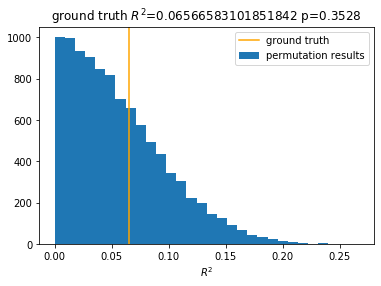

(0.06566583101851842, 0.3528)

In [21]:
icn_permutation_test.permutationTest(df_best[(df_best["lat"]=="CON") & (df_best["loc"] == "ECOG")]["r2"],
                                    df[(df["lat"]=="CON") & (df["loc"] == "ECOG")]["r2"], True,
                                    r"$R^2$", 10000)

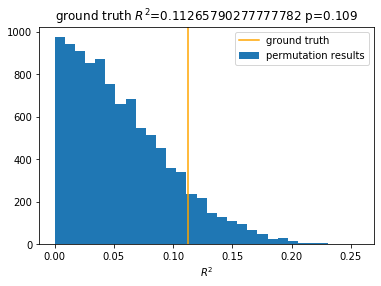

(0.11265790277777782, 0.109)

In [22]:
icn_permutation_test.permutationTest(df_best[(df_best["lat"]=="IPS") & (df_best["loc"] == "ECOG")]["r2"],
                                    df[(df["lat"]=="IPS") & (df["loc"] == "ECOG")]["r2"], True,
                                    r"$R^2$", 10000)

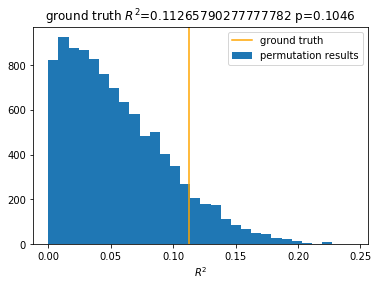

(0.11265790277777782, 0.1046)

In [23]:
icn_permutation_test.permutationTest(df_best[(df_best["lat"]=="IPS") & (df_best["loc"] == "ECOG")]["r2"],
                                    df[(df["lat"]=="IPS") & (df["loc"] == "ECOG_STN")]["r2"], True,
                                    r"$R^2$", 10000)

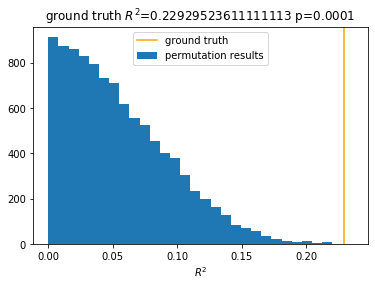

(0.22929523611111113, 0.0001)

In [24]:
icn_permutation_test.permutationTest(df_best[(df_best["lat"]=="IPS") & (df_best["loc"] == "STN")]["r2"],
                                    df[(df["lat"]=="IPS") & (df["loc"] == "STN")]["r2"], True,
                                    r"$R^2$", 10000)

Text(0.5, 1.0, 'XGB Cross Validation $R^2$ results\nECOG con: 0.34$\\pm$0.23 ips: 0.19$\\pm$0.2\nSTN con: 0.1$\\pm$0.17 ips: 0.03$\\pm$0.1\nECOG_STN con: 0.4$\\pm$0.18 ips: 0.31$\\pm$0.2')

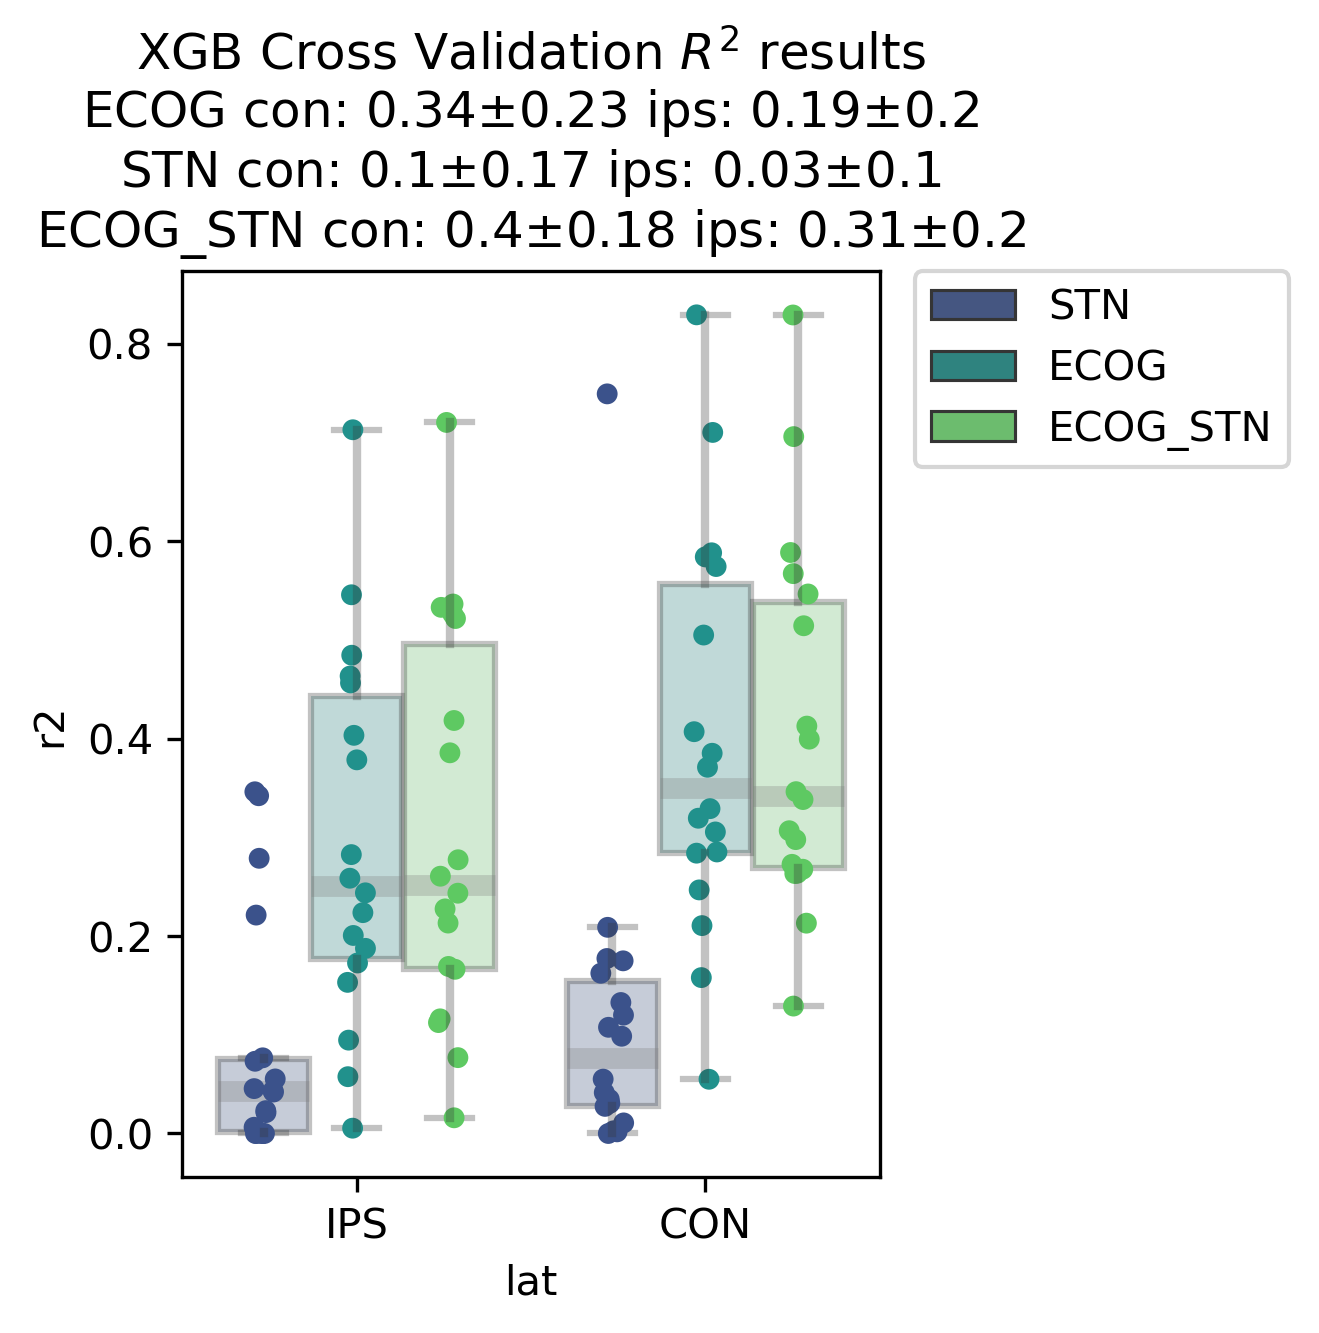

In [54]:
alpha_box = 0.3
plt.figure(figsize=(3,4), dpi=300)
sb.boxplot(x="lat", y="r2", hue="loc", order=["IPS", "CON"], hue_order=["STN", "ECOG", "ECOG_STN"], data=df,
           palette="viridis", 
           showmeans=False, boxprops=dict(alpha=alpha_box), showcaps=True, showbox=True, 
           showfliers=False, notch=False,
           whiskerprops={'linewidth':2, "zorder":10, "alpha":alpha_box},
           capprops={"alpha":alpha_box},
           medianprops=dict(linestyle='-.', linewidth=5, color="gray", alpha=alpha_box))

    
ax = sb.stripplot(x="lat", y="r2", hue="loc", order=["IPS", "CON"], hue_order=["STN", "ECOG", "ECOG_STN"],
             data=df, palette="viridis", dodge=True, s=5)
#plt.xticks(rotation=90)

# When creating the legend, only use the first two elements
# to effectively remove the last two.
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:3], labels[0:3], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("XGB Cross Validation "+r"$R^2$"+" results\n"+
         "ECOG con: "+s_ECOG_CON+ " ips: "+s_ECOG_IPS+\
         "\nSTN con: "+s_STN_CON+ " ips: "+s_STN_IPS+\
         "\nECOG_STN con: "+s_ECOGSTN_CON+ " ips: "+s_ECOGSTN_IPS)


Text(0.5, 1.0, 'XGB Cross Validation $R^2$ results\nECOG con: 0.34$\\pm$0.23 ips: 0.19$\\pm$0.2\nSTN con: 0.1$\\pm$0.17 ips: 0.03$\\pm$0.1\nECOG_STN con: 0.4$\\pm$0.18 ips: 0.31$\\pm$0.2')

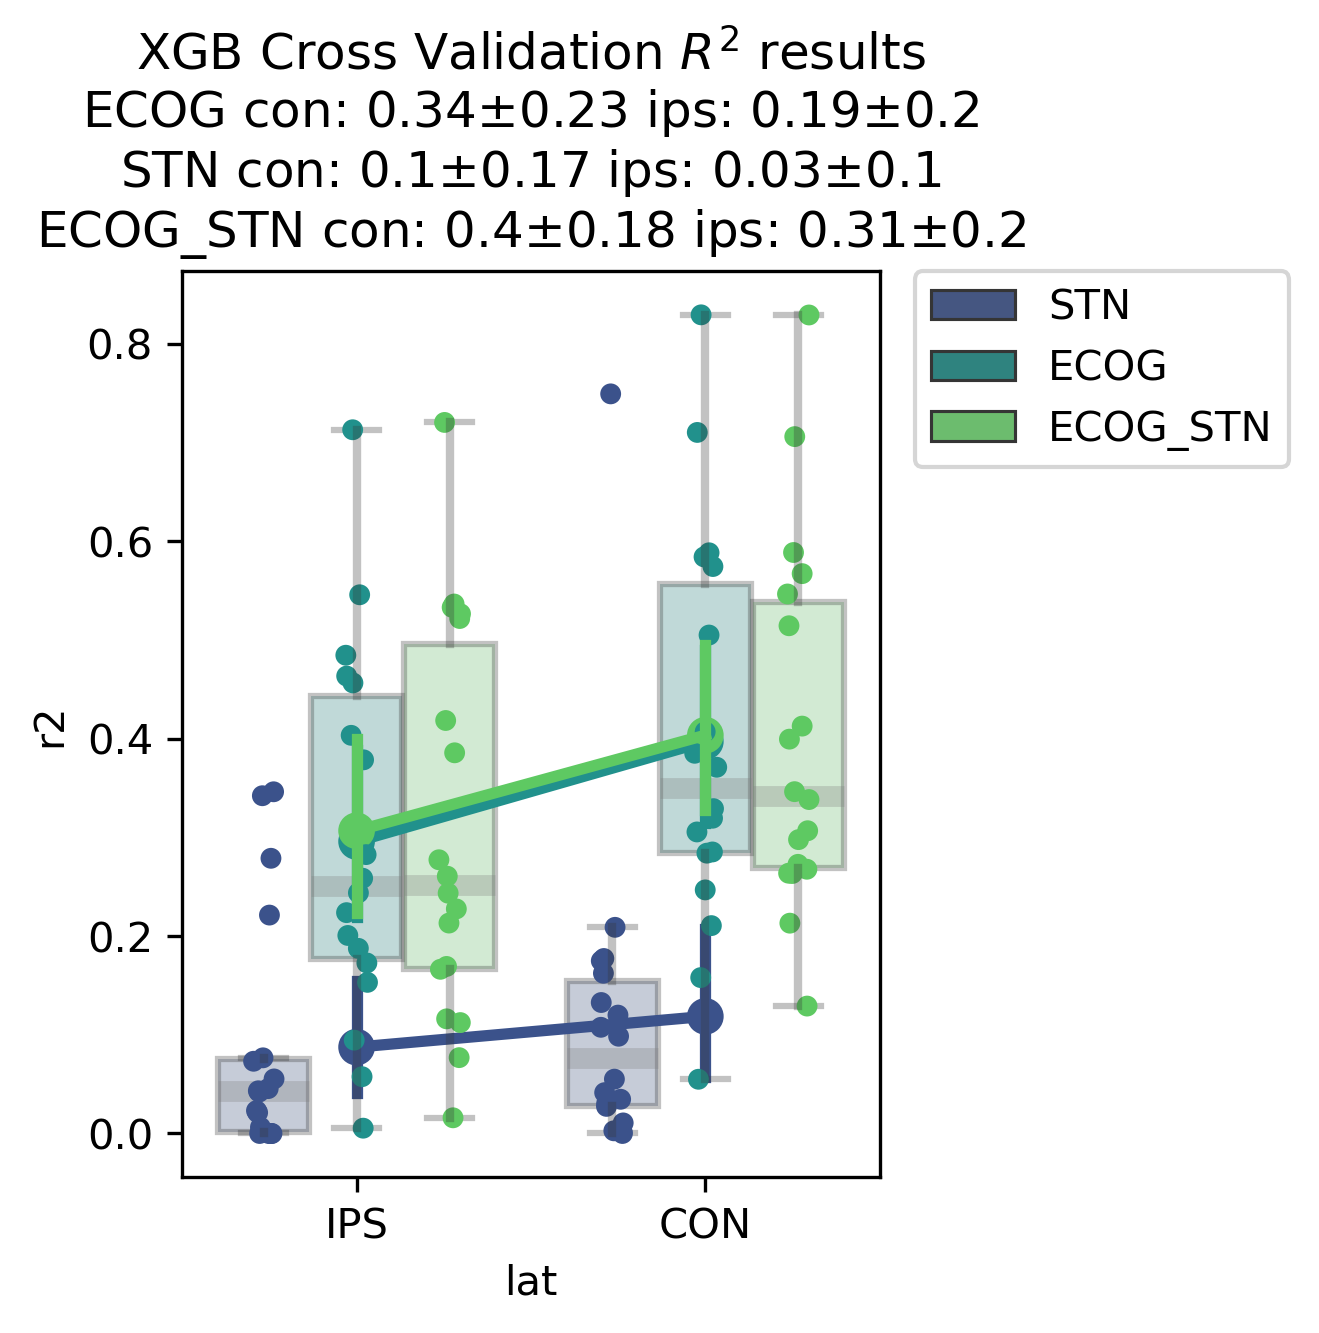

In [60]:
alpha_box = 0.3
plt.figure(figsize=(3,4), dpi=300)
sb.boxplot(x="lat", y="r2", hue="loc", order=["IPS", "CON"], hue_order=["STN", "ECOG", "ECOG_STN"], data=df,
           palette="viridis", 
           showmeans=False, boxprops=dict(alpha=alpha_box), showcaps=True, showbox=True, 
           showfliers=False, notch=False,
           whiskerprops={'linewidth':2, "zorder":10, "alpha":alpha_box},
           capprops={"alpha":alpha_box},
           medianprops=dict(linestyle='-.', linewidth=5, color="gray", alpha=alpha_box))

sb.pointplot(x="lat", y="r2", hue="loc", order=["IPS", "CON"], hue_order=["STN", "ECOG", "ECOG_STN"], data=df,
           palette="viridis", alpha=alpha_box)
    
ax = sb.stripplot(x="lat", y="r2", hue="loc", order=["IPS", "CON"], hue_order=["STN", "ECOG", "ECOG_STN"],
             data=df, palette="viridis", dodge=True, s=5)
#plt.xticks(rotation=90)

# When creating the legend, only use the first two elements
# to effectively remove the last two.
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:3], labels[0:3], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("XGB Cross Validation "+r"$R^2$"+" results\n"+
         "ECOG con: "+s_ECOG_CON+ " ips: "+s_ECOG_IPS+\
         "\nSTN con: "+s_STN_CON+ " ips: "+s_STN_IPS+\
         "\nECOG_STN con: "+s_ECOGSTN_CON+ " ips: "+s_ECOGSTN_IPS)


Text(0.5, 1.0, 'XGB Performance comparison for combined channels')

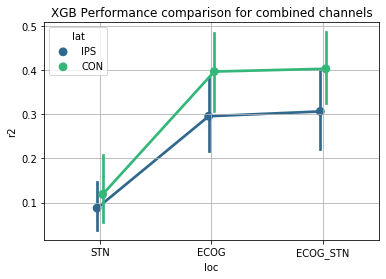

In [82]:
sb.pointplot(x ="loc", y="r2", hue="lat", hue_order=["IPS", "CON"], 
           order=["STN", "ECOG", "ECOG_STN"], data=df,
           palette="viridis", alpha=0.3, dodge=True)
plt.grid(True)
plt.title("XGB Performance comparison for combined channels")

In [70]:
sb.pointplot?

In [57]:
df[(df["loc"] == "ECOG") & (df["lat"] == "CON")]

,ch_,lat,loc,r2,sub
1,ECOG_RIGHT_5,CON,ECOG,0.829167,000
2,ECOG_LEFT_27,CON,ECOG,0.710066,001
5,ECOG_RIGHT_27,CON,ECOG,0.583997,001
6,ECOG_LEFT_7,CON,ECOG,0.246710,004
9,ECOG_RIGHT_7,CON,ECOG,0.370936,004
10,ECOG_LEFT_7,CON,ECOG,0.385104,005
13,ECOG_RIGHT_7,CON,ECOG,0.157897,005
14,ECOG_LEFT_34,CON,ECOG,0.329030,006
16,ECOG_LEFT_35,CON,ECOG,0.504857,006
18,ECOG_LEFT_35,CON,ECOG,0.574244,006
